In [1]:
!nvidia-smi

Wed Aug 16 13:53:02 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |   1355MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   30C    P8     9W / 180W |   2931MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import keras
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, LSTM, Activation
from keras.layers import Dropout, GRU, Bidirectional, Conv2D, Conv1D
from keras.layers import MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, l1
from keras.models import Sequential
from tracker3d import loader, utils, metrics

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


In [4]:
%%time
order        = ("r", "phi", "z")
code         = (order[0][0] + order[1][0] + order[2][0]).upper()
n_noise      = 0
num_classes  = (25 + 2)
input_shape  = ((25 * 9), 3)
load_file    = np.load("datasets/npz/UNIF-25T-1000E-{0}-{1}N.npz".format(code, n_noise))
train_data   = pad_sequences(load_file["arr_0"], maxlen=input_shape[0], padding="post", dtype=float)
train_target = [utils.to_categorical(seq, num_classes) for seq in load_file["arr_1"]]
train_target = pad_sequences(train_target, maxlen=(9 * 25), padding="post")
opt          = "rmsprop"
modelpath    = "models/BIG-1000E-{0}-{1}N.h5".format(code, n_noise)

for matrix in train_target:
    for row in matrix:
        if row.sum() == 0:
            row[-1] = 1

CPU times: user 19.8 s, sys: 25.2 s, total: 44.9 s
Wall time: 44.9 s


In [8]:
test_data, test_target = loader.from_frame(pd.read_csv("datasets/raw/RAMP-Z.csv"), order=order,
                                          preferred_rows=input_shape[0], preferred_tracks=num_classes)

All finished. Loaded in 3600.


In [5]:
utils.display_side_by_side(train_data[3], train_target[3], order=order)

,r,phi,z
0,39.0,-2.955522,-6.318352
1,39.0,-2.769280,-6.751662
2,39.0,-2.509096,1.360140
3,39.0,-2.266164,-5.394237
4,39.0,-2.229423,-6.981087
5,39.0,-1.933214,6.556314
6,39.0,-1.850637,5.524789
7,39.0,-0.084103,5.161825
8,39.0,-0.024547,-4.396384
9,39.0,0.198745,7.705459


In [6]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
%%time
model = Sequential()
model.add(Bidirectional(
    GRU(300, return_sequences=True, dropout=1/2, implementation=2), input_shape=input_shape, merge_mode="mul"))
model.add(Bidirectional(
    GRU(300, return_sequences=True, dropout=1/2, implementation=2), merge_mode="mul"))
model.add(Bidirectional(
    GRU(300, return_sequences=True, dropout=1/2, implementation=2), merge_mode="mul"))
model.add(TimeDistributed(Dense(units=num_classes, kernel_initializer="uniform", activation="softmax")))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.summary()

In [ ]:
%%time
epochs = 164
batch_size = 60
valsplit = 0.1
modelpath = "models/BIG-1000E-{0}-{1}N.h5".format(code, n_noise)
hist = model.fit (
    train_data,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_split=valsplit,
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath=modelpath,
        save_best_only=True
    )]
)

In [11]:
guesses = model.predict(test_data)
print(metrics.discrete_accuracy_all(test_data, guesses, test_target))

0.746303987966


<IPython.core.display.Javascript object>


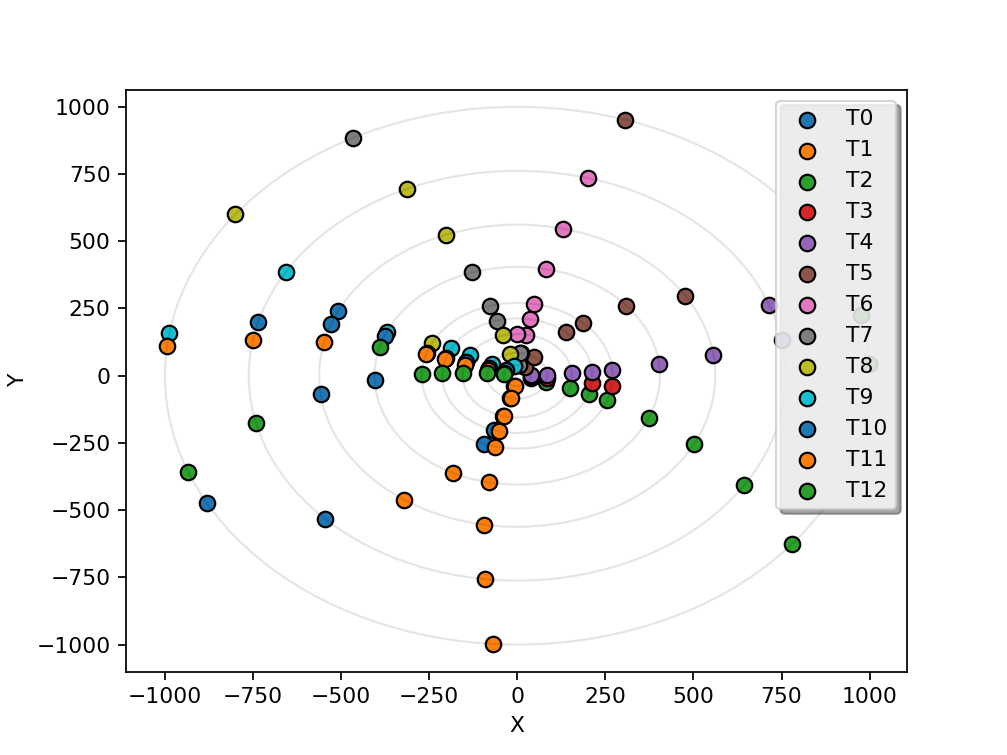

In [19]:
e = np.random.randint(len(test_data))
utils.plot3d(test_data[e], guesses[e], test_target[e], has_noise=False, order=order, flat_ax="z")